## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors,tree, preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, recall_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
import re
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

###### PRINT CONFUSION MATRIXES
def confusion (y_true,y_predict,x):
    cm = confusion_matrix(y_true, y_predict)
    y = np.unique(y_true)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(cm.T, cmap="coolwarm", square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(y),
                yticklabels=(y))
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.title('Confusion Matrix - {} Set'.format(x))
    
    if len(y)==2:
        tn, fp, fn, tp = cm.ravel()
        print("True Negatives:{}".format(tn))
        print("False Positives:{}".format(fp))
        print("False Negatives:{}".format(fn))
        print("True Positives:{}".format(tp))
    else:
        print("Not binary")
           
####### PRINT DATASET STATUS
def set_dist (y,x):
    print("{}".format(x))
    for i in np.unique(y):
        print("{}: {}".format(i,np.count_nonzero(y == i)))
        
###### MODEL PIPELINE
def model (intro,xtrain,ytrain,xtest,ytest,model):
    print ("{}\n".format(intro))
    md = model.fit(xtrain,ytrain)
    print("Accuracy on training set:\n")
    trainscore = md.score(xtrain, ytrain)
    print("{}\n".format(trainscore))
    ytrainp = md.predict(xtrain)
    print('Classification report (train):')
    print(classification_report(ytrain,ytrainp))
    print("Accuracy on test set:\n") 
    testscore = md.score(xtest, ytest)
    print("{}\n".format(testscore))
    ytestp = md.predict(xtest)
    print('Classification report (test):')
    print(classification_report(ytest,ytestp))
    return ytrainp, ytestp, trainscore, testscore

In [242]:
df = pd.read_csv('PetFinder_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Loading colour, breed and state labels:

In [243]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### Are the supposedly unique identifiers actually unique? What does it mean if they aren't?
PetID.

#### When data entries are blank, where does that come from?
The only blank entries in this dataset correspond to animal profiles without an assigned name.

#### How common are blank entries?
There are ~1200 blank entries, which constitute a significant portion of the data. Given this number, and due to the fact that blank entries have meaning attributed to them, it would perhaps be best to keep this data in the dataset for analysis.

## Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

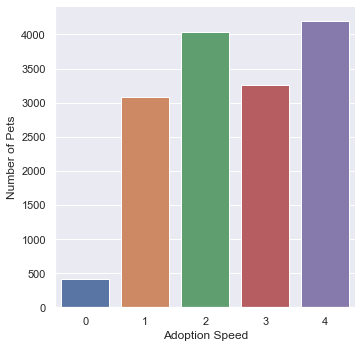

In [244]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

### Overall correlations
The plot bellow illustrates the absolute correlation between  each feature and the target class "AdoptionSpeed". All correlations are very low (<15%)

([<matplotlib.axis.XTick at 0x280c6d1a7c8>,
 <a list of 19 Text xticklabel objects>)

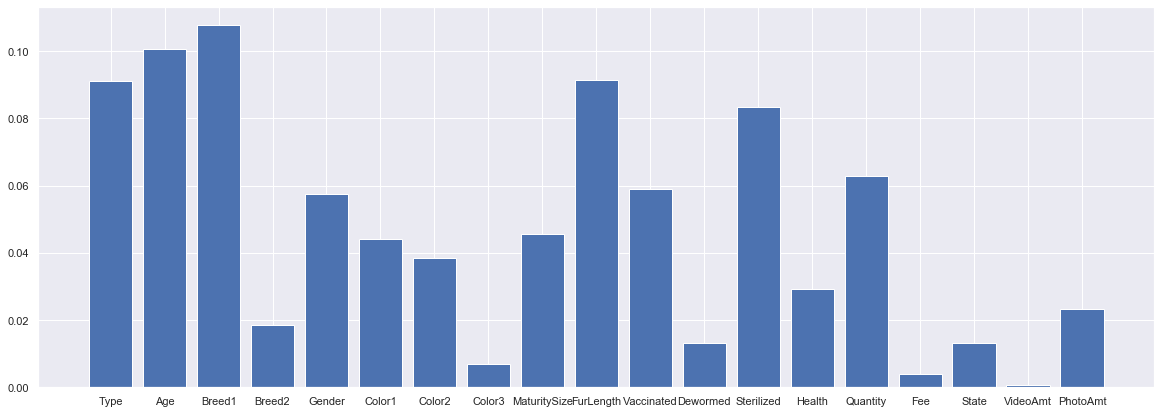

In [245]:
numeric_df = df.select_dtypes(exclude=['object'])
corr_dict = {}
for feature in numeric_df.columns:
    corr_dict[feature] = abs(df['AdoptionSpeed'].corr(df[feature]))
    #print(feature, '-->', corr_dict[feature])
    
corr_dict.pop('AdoptionSpeed')
plt.figure(figsize=(20,7))
plt.bar(range(len(corr_dict)), list(corr_dict.values()), align='center')
plt.xticks(range(len(corr_dict)), list(corr_dict.keys()))

### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [246]:
df.set_index("PetID", inplace=True) # change index to PetId
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


### Strategy

The following analysis was done to each feature:
* Check the number of examples for each feature values.
* Check the distribution of each feature values' among AdoptionSpeed classes.

For the second step we used the following visualisation method, which returns not only a plot on the distribution but also a table of representativity percentage gain of each feature's values for each AdoptionSpeed class, relatively to AdoptionSpeed=0:

In [247]:
# creates a stacked bar plot for any two categorical variables
# also creates a relative frequency version of the same plot
# and a relative gain compared to AdoptionSpeed=0 
# frel=False to return only the absolute frequency plot

def cat_distr_pairwise(cat_x,cat_y, df, frel):
    
    unique_cat_y = sorted(df[cat_y].unique())
    unique_cat_x = sorted(df[cat_x].unique())
    cat_count = pd.DataFrame(columns=unique_cat_y,index=unique_cat_x)
    for y in unique_cat_y:
        for x in unique_cat_x:
            count = df[cat_y][(df[cat_x]==x) & (df[cat_y]==y)].count()
            cat_count.at[x,y] = count 
    
    def color(val):
        if val < 0:
            color = 'red'
        elif val>0:
            color = 'green'
        else:
            color='white'
        return 'background-color: %s' % color
    
    if frel==False:
        
        #relative gain table
        relgain = cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        return cat_count.plot.bar(stacked=True, figsize=(10,7))
    
    else:
        #relative frequency stacked bar plot
        freq_cat_count = cat_count.divide(cat_count.sum(axis=1), axis=0)
        
        #relative gain table
        relgain = freq_cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))

        return freq_cat_count.plot.bar(stacked=True, figsize=(10,7), title=cat_y + " relative distribution among AdoptionSpeed")
    

We will now present the most important conclusions taken from this analysis.

### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

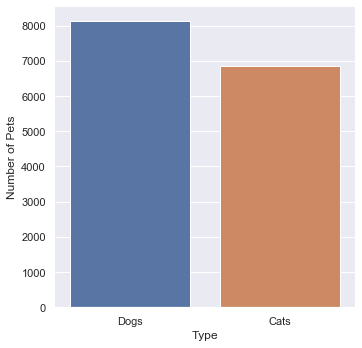

In [248]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

Relative gain from AdoptionSpeed=0 (%):


,1,2
0,nan,nan
1,12.0027,-8.50189
2,27.429,-21.8776
3,38.9943,-35.2397
4,35.1712,-29.5518


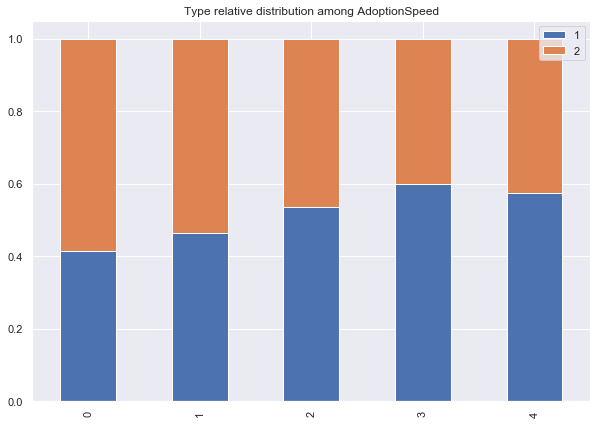

In [249]:
cat_distr_pairwise('AdoptionSpeed','Type', df, frel=True)

Looking at our data, the number of examples of dogs and cats is fairly proportional, as well as their relative distribution among target classes. 
Looking at the gain table, it is clear that dogs(1) tend to get adopted later relatively to cats(2),  which we can see by the growing relative gain. In fact, the number of dogs with no adoption after 100 days (adoptionSpeed=4) is 37% higher than dogs being adopted on the same day (adoptionSpeed=0). On the other hand, we observe the opposite phenomena on cats. They tend to be adopted at ealier stages, being the number of cats with no adoption after 100 days (adoptionSpeed=4) is 29% lower than cats being adopted on the same day (adoptionSpeed=0).
Despite this small discrepancies, we expect the resulting models' performance to be comparable.



### Name
Since a reasonable amount of the profiles didn't make any reference to name (empty) a first approach would be to fill those empty values with a fixed value such as "No Name" or similar.
Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite.
Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", "V6", "å°è±¹çº¹" etc., which are not proper names, we made an attempt to classify those cases as "No name" as well.

A glimpse on the ignored names: ['No Name Yet', 'No Name', 'No Name', 'H3', 'Z3', 'C', 'No Name', 'No Name', 'BB', 'QQ', 'Y1', 'No Name', 'H1', 'No Name Yet', 'D9', 'Y4', 'No Name', 'Z4', 'No Name', 'Unnamed', 'BB', 'DD', 'M2', 'H6', 'D4', 'QQ', 'JJ', 'No Names', 'å°\x8fè±¹çº¹', 'ä¼\x98ç¾\x8eå\x8f¯ç¬\x91', 'F1', 'æ©\x98å\xad\x90', 'W7', '(No Name)', 'No Name Yet', 'No Name', '1F', 'Q1', '6', 'CJ', '3F', '[No Name]', 'BB', 'KD', 'No Name Yet', 'No Name Yet', 'DD', 'No Name', 'G1', 'è\x8f\x9cè\x8f\x9cã\x80\x82']


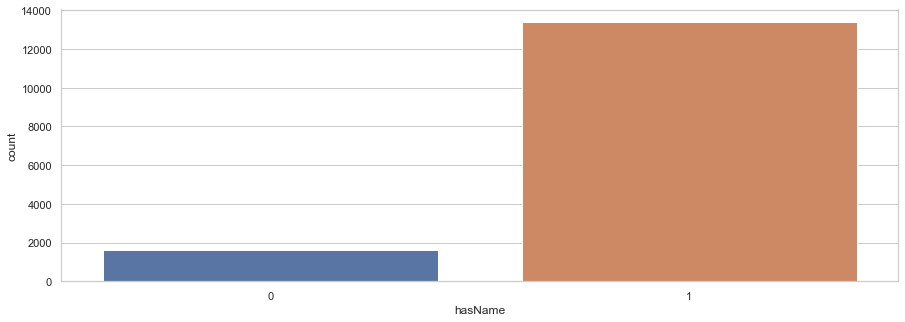

In [250]:
# Create new feature - hasNames
l = []
ignore = []

for i in df["Name"]:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        if len(i)<3: #Consider that a 2 letter name is not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("[a-zA-Z]", i) == None: #If name doesn't have letters, it's not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("unnamed|no name",i, re.IGNORECASE) != None: 
            #If name string includes "unnamed" or "no name", it's not a proper name
            l.append(0)
            ignore.append(i)
        elif len(i.split())>0:
            l.append(1)

print("A glimpse on the ignored names:",ignore[:50])
df_processed1 = df.copy()
df_processed1.drop("Name", axis=1, inplace = True)
df_processed1.insert(1,"hasName",l) ##INSERT IN DATAFRAME

sns.set(style="whitegrid")
ax = sns.countplot(x="hasName", data=df_processed1)

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,28.3828,-2.81545
2,14.3321,-0.974261
3,9.85559,-0.479193
4,38.1045,-3.44873


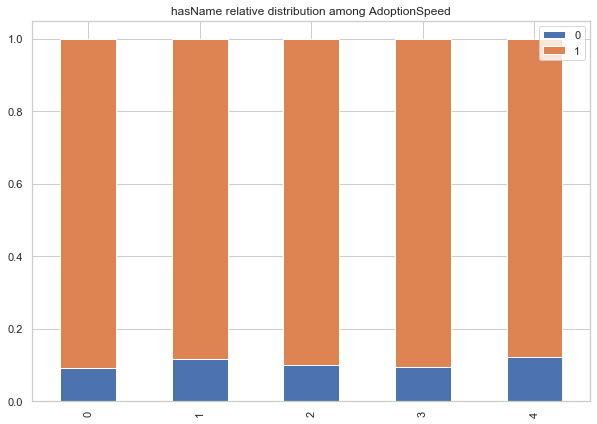

In [251]:
cat_distr_pairwise('AdoptionSpeed','hasName', df_processed1, frel=True)

As we can see from the plot above, the relative distribution of the "noName" feature values among "AdoptionSpeed" classes is very similar. This probabably means that the pet's name is not a very important factor in the adopter's decision.

### Age

When looking at the Age distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

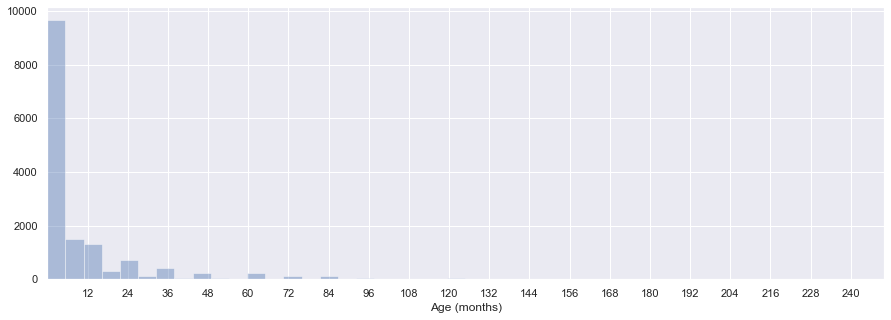

In [252]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months => 0
* Adult - age 12-71 months =>1
* Senior - age 72-250 months =>2

In [253]:
# Create new feature - AgeGroup
AgeGroup = []
for i in df["Age"]:
    if i<12:
        AgeGroup.append(0)
    elif i<72:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)

df_processed2 = df_processed1.copy()
df_processed2.drop("Age", axis=1, inplace = True)
df_processed2.insert(2,"AgeGroup",AgeGroup) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1,2
0,nan,nan,nan
1,11.4206,-27.3511,-52.4542
2,11.9318,-35.1685,18.4303
3,7.09603,-14.0861,37.1413
4,-10.7473,54.0975,42.645


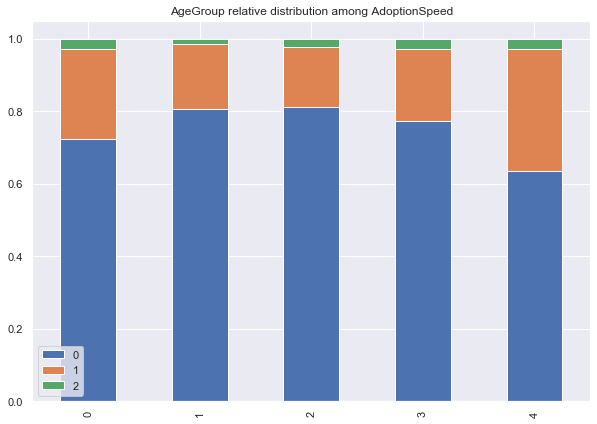

In [254]:
cat_distr_pairwise('AdoptionSpeed','AgeGroup', df_processed2, frel=True)

The relative distribution of AgeGroups among AdoptionSpeed indicates that there seems to be no particular correlation between being younger and getting adopted earlier. Even without the dicretization we can observe the same phenomena: 

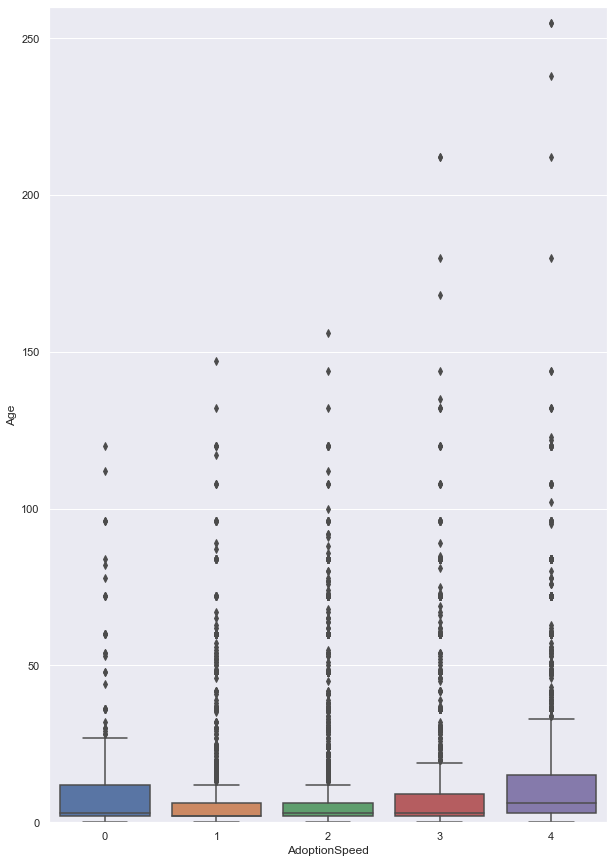

In [255]:
plt.figure(figsize=(10,15))
plt.ylim(0, 260)
sns.boxplot(data = df, x='AdoptionSpeed', y='Age')

### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

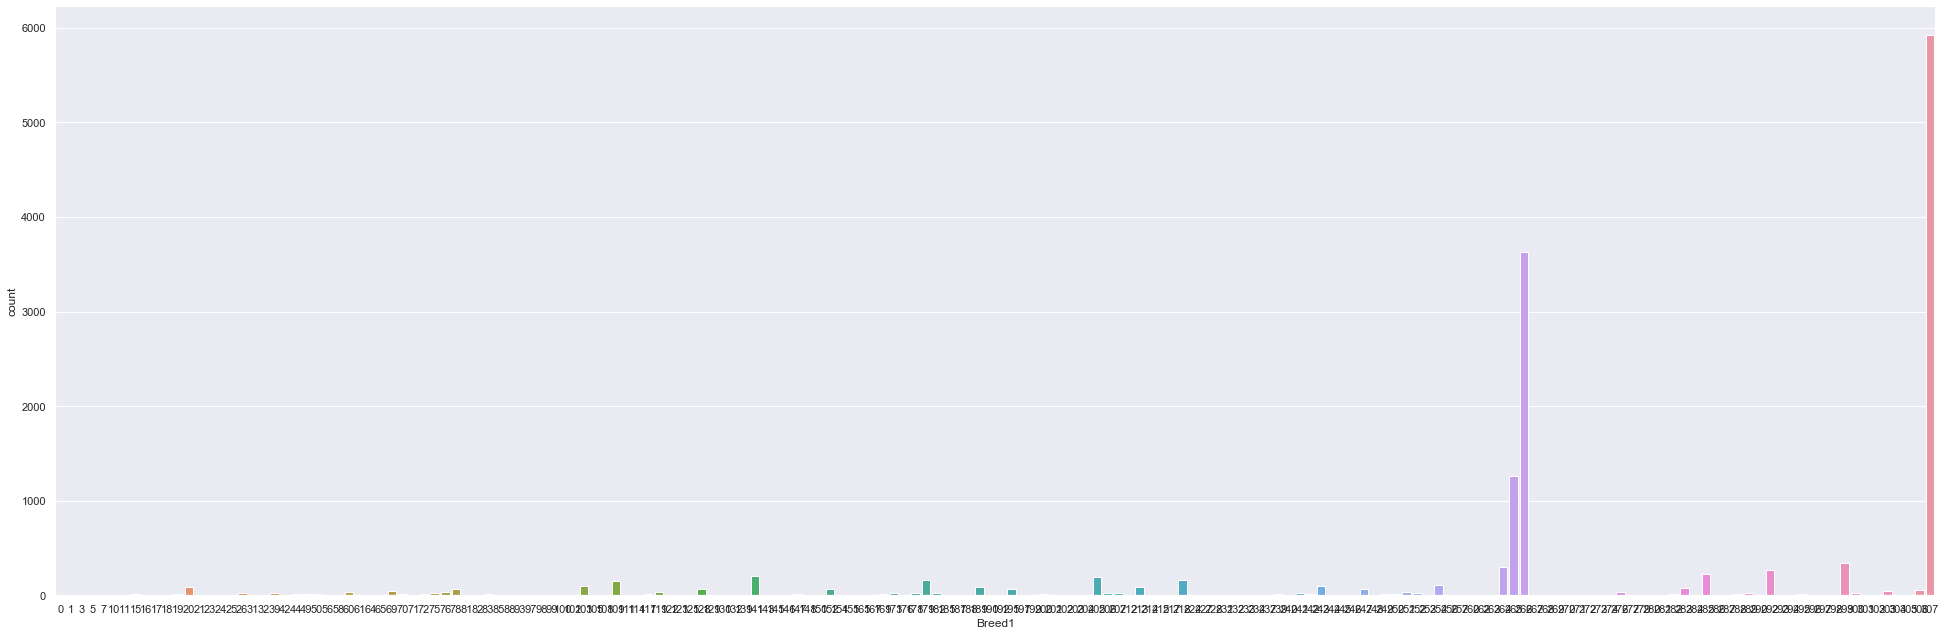

In [ ]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race.

In [ ]:
#Creating new feature: Pure breed
l3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        l3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        l3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        l3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        l3.append(1)
    else:
        l3.append(0)
        
df_processed2.drop("Breed1",axis=1,inplace=True)
df_processed2.drop("Breed2",axis=1,inplace=True) 
df_processed2.insert(3,'PureBreed',l3) ##INSERT IN DATAFRAME

In [ ]:
cat_distr_pairwise('AdoptionSpeed','PureBreed', df_processed2, frel=True)

From the plot and relative gain table we conclude that pure breed animals (1) tend to be adopted earlier, whereas mixed breed animals (0) are adopted later.

### Color1, Color2 and Color3

Each pet has at least one main color (color1) that according to the colors features label can go from black(1) to white(7). Pets can also have one or two additional colors (color2 and color3) with the same categorical values as the main color.

In [ ]:
#zx1 = sns.catplot(x="Color1",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx1.set_axis_labels("Color 1", "Number of Pets"))
#zx2 = sns.catplot(x="Color2",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx2.set_axis_labels("Color 2", "Number of Pets"))
#zx3 = sns.catplot(x="Color3",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx3.set_axis_labels("Color 3", "Number of Pets"))

color1= cat_distr_pairwise('AdoptionSpeed','Color1', df, frel=True)

In [ ]:
color2 = cat_distr_pairwise('AdoptionSpeed','Color2', df, frel=True)

In [ ]:
color3 = cat_distr_pairwise('AdoptionSpeed','Color3', df, frel=True)

Given the number of values for each color feature one of the following approaches should be appropriate to address the Color1, Color2 and Color3 features: 
* Group pets according to the number of colors one has. Pets with only one color will be assigned a "SingleColor" feature and so on;
* Group colours according to their brightness/darkness.

However we will leave further considerations on the feature engineering part later on this document.

### Quantity

Number of pets represented in profile

In [ ]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

In [ ]:
ste = cat_distr_pairwise('AdoptionSpeed','Quantity', df, frel=True)

The "inf" values on the table indicate that there are no examples of a pet with AdoptionSpeed=0 for that feature instance. Therefore, all positive relative gains are 'infinite'.

We can conclude that adds containing more than 5 pets could be more likely to be ignored, since those pets are adopted after a long time.

### Fee

After observing the fees distribution we considered 4 categories: 
* Free => 0
* Tens => 1
* Hundreds => 2
* Thousands => 3


In [ ]:
f=[]
for i in df["Fee"]:
    if i==0:
        f.append(0)
    elif i<100:
        f.append(1)
    elif i<1000:
        f.append(2)
    else:
        f.append(3)

df_processed2.drop("Fee",axis=1,inplace=True) 
df_processed2.insert(4,'Free',f) ##INSERT IN DATAFRAME

In [ ]:
fee = cat_distr_pairwise('AdoptionSpeed','Free', df_processed2, frel=True)

It seems that pets with fees in the order of the thousands are less likely to be adopted fast.

### RescuerID

In order to extract some meaning from the 'RescuerID', we decided to create a new feature "FrequentRescuer" which indicates whether it is frequent for rescuers to save and advertise pets.

In [ ]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append(y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} total rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover whether the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

In [ ]:
#CREATE NEW FEATURE FREQUENTRESCUER

lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df_processed1.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed1.drop("RescuerID", axis=1)

df_processed2.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed2.drop("RescuerID", axis=1)

### VideoAmt

In [ ]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

In [ ]:
vid = cat_distr_pairwise('AdoptionSpeed','VideoAmt', df, frel=True)

### Photo Amt

xxxxxxxxxxxx.

In [ ]:
ax1 = sns.catplot(x='PhotoAmt', data=df, kind='count',height=4, aspect=3)
(ax1.set_axis_labels("Photo Amount", "Number of Pets"))

In [ ]:
pht = cat_distr_pairwise('AdoptionSpeed','PhotoAmt', df, frel=True)

### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

In [ ]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0.0,1300])

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words => 0
* 'Small' for descriptions containing 1-28 words => 1
* 'Medium' for descriptions containing 29-65 words => 2
* 'Large' for descriptions containing 66-1257 words => 3

In [ ]:
#Create new feature 'Description size'
d = []

for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        d.append(0)
    else:
        a= len(i.split())
        if a<29:
            d.append(1)
        elif a<66:
            d.append(2)
        else:
            d.append(3)
         
df_processed1.drop("Description", axis=1)
df_processed1.insert(6,"DescriptionSize",l) ##INSERT IN DATAFRAME

df_processed2.drop("Description", axis=1)
df_processed2.insert(6,"DescriptionSize",d) ##INSERT IN DATAFRAME

### Other conclusions
* Pets with maturity size 'Small' (1) and 'Extra Large'(4) are less likely to be in the adoption centre for a very long time (-45.0552% and -97.3772 of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1, respectively). 
* Pets with long fur(3) very rarely stay at the adoption centre for a long time (-116.814% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Sterilized pets tend to be adopted later (+82.13% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Pets with serious injuries (Health=3) are very more likely to be adopted after a long time, or not adopted at all (+182.091% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1). 
* No pets were adopted in the same day having the add not provide a description!
* There was no clear evidence that the distribution of the features values among AdoptionSpeed classes was biased for features Gender, Vaccinated, Dewormed, States, FrequentRescuer.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

## 1.1. Preprocessing Data for Classification

During our EDA we already preprocessed some of the features, for data visualization purposes. The result are two datasets:
* **df_processed1**: which we will use to benchmark the models' performance without the discretization of features discussed earlier, since they can remove the fine grain information that might be beneficial to the learning proccess. Some data cleaning was done, namely in features PetID, Name, RescuerID and DescriptionSize (in words, instead of text Description).

* **df_processed2**: which is the data set with the derived features and data cleaning. We will see if the dicretization will be helpful for the models or not.

### Data imbalancement
XXXXXX
-- use df_processed2 for this. df_processed1 is just for benchmarking.

#### Binary Classification - Random Over-Sampling

In [ ]:
df_processed2_b_balanced = df_processed2.copy()
df_processed2_b_balanced = df_processed2_b_balanced.rename(columns={'AdoptionSpeed': 'Adoption'})
df_processed2_b_balanced = df_processed2_b_balanced.replace({'Adoption':[0,2,3]},1)
df_processed2_b_balanced = df_processed2_b_balanced.replace({'Adoption':4},0)

In [ ]:
df_processed2_b_balanced_ROA = df_processed2_b_balanced.copy()
ros_b = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_ros_b, y_ros_b = ros_b.fit_resample(df_processed2_b_balanced_ROA.iloc[:,:-1], df_processed2_b_balanced_ROA['Adoption'])

df_processed2_b_balanced_ROA = X_ros_b.join(y_ros_b)

#### Multiclass classification - Random Over-Sampling

In [ ]:
df_processed2_m_balanced = df_processed2.copy()

In [ ]:
df_processed2_m_balanced_ROA = df_processed2_m_balanced.copy()
ros_m = RandomOverSampler(random_state=42)
X_ros_m, y_ros_m = ros_m.fit_resample(df_processed2_m_balanced_ROA.iloc[:,:-1], df_processed2_m_balanced_ROA['AdoptionSpeed'])

df_processed2_m_balanced_ROA = X_ros_m.join(y_ros_m)

#### Dogs - Random Over-Sampling

##### Binary Classification

In [ ]:
df_processed2_b_dog = df_processed2_b_balanced.copy()

df_processed2_b_dog = df_processed2_b_dog[df_processed2_b_dog['Type']==1]

In [ ]:
df_processed2_b_dogs_ROA = df_processed2_b_dog.copy()
ros_b_dogs = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_ros_b_dogs, y_ros_b_dogs = ros_b_dogs.fit_resample(df_processed2_b_dogs_ROA.iloc[:,:-1], df_processed2_b_dogs_ROA['Adoption'])

df_processed2_b_dogs_ROA = X_ros_b_dogs.join(y_ros_b_dogs)

##### Multiclass classification

In [ ]:
df_processed2_m_dogs = df_processed2_m_balanced.copy()
df_processed2_m_dogs = df_processed2_m_dogs[df_processed2_m_dogs['Type']==1]

In [ ]:
df_processed2_m_dogs_ROA = df_processed2_m_dogs.copy()

ros_m_dogs = RandomOverSampler(random_state=42)
X_ros_m_dogs, y_ros_m_dogs = ros_m_dogs.fit_resample(df_processed2_m_dogs_ROA.iloc[:,:-1], df_processed2_m_dogs_ROA['AdoptionSpeed'])

df_processed2_m_dogs_ROA = X_ros_m_dogs.join(y_ros_m_dogs)

#### Cats - Random Over-Sampling

##### Binary Classification

In [ ]:
df_processed2_b_cats = df_processed2_b_balanced.copy()

df_processed2_b_cats = df_processed2_b_cats[df_processed2_b_cats['Type']==2]

In [ ]:
df_processed2_b_cats_ROA = df_processed2_b_cats.copy()

ros_b_cats = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_ros_b_cats, y_ros_b_cats = ros_b_cats.fit_resample(df_processed2_b_cats_ROA.iloc[:,:-1], df_processed2_b_cats_ROA['Adoption'])
df_processed2_b_cats_ROA = X_ros_b_cats.join(y_ros_b_cats)

##### Multiclass classification

In [ ]:
df_processed2_m_cats = df_processed2_m_balanced.copy()
df_processed2_m_cats = df_processed2_m_cats[df_processed2_m_cats['Type']==2]

In [ ]:
df_processed2_m_cats_ROA = df_processed2_m_cats.copy()

ros_m_cats = RandomOverSampler(random_state=42)
X_ros_m_cats, y_ros_m_cats = ros_m_cats.fit_resample(df_processed2_m_cats_ROA.iloc[:,:-1], df_processed2_m_cats_ROA['AdoptionSpeed'])
df_processed2_m_cats_ROA = X_ros_m_cats.join(y_ros_m_cats)

## 1.2. Learning Classifiers

## Benchmark

#### FEATURE ENCODING

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## 'Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_processed1[['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name = encoder.get_feature_names(['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_encoded =  pd.DataFrame(df_encoded, columns= column_name)

print(column_name) #encoded features names

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_encoded.insert(0,'PetID',df_processed1.index.tolist()) ## PetID
df_processed1_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_encoded.insert(2,'hasName',df_processed1['hasName']) ## hasName  
df_processed1_encoded.insert(3,'Age',df_processed1['Age']) ## AGE  
df_processed1_encoded.insert(4,'DescriptionSize',df_processed1['DescriptionSize']) ## DescriptionSize  
df_processed1_encoded.insert(5,'Quantity',df_processed1['Quantity']) ## QUANTITY    
df_processed1_encoded.insert(6,'Fee',df_processed1['Fee']) ## FEE  
df_processed1_encoded.insert(7,'FrequentRescuer',df_processed1['FrequentRescuer']) ## FrequentRescuer  
df_processed1_encoded.insert(8,'VideoAmt',df_processed1['VideoAmt']) ## VideoAmt  
df_processed1_encoded.insert(9,'PhotoAmt',df_processed1['PhotoAmt']) ## PhotoAmt
df_processed1_encoded.insert((len(df_processed1_encoded.columns)),'AdoptionSpeed',df_processed1['AdoptionSpeed']) ## AdoptionSpeed

print(df_processed1_encoded.columns.values) ## data frame for training

In [ ]:
nc = df_processed1_encoded.shape[1]
matrix = df_processed1_encoded.values # Convert dataframe to darray
examples = matrix [:, 0:nc-1] # get features 
target = matrix [:, nc-1] # get class (last columns)           
fnames = df_processed1_encoded.columns.values[0:nc-1] #get features names
tname = df_processed1_encoded.columns.values[nc-1] #get target name

examples = examples.astype(float)
target = target.astype(float)

In [ ]:
## split data frame into test and train sets
X_train, X_test, y_train, y_test = train_test_split(examples, target, random_state=0)

print(X_train.shape)
print(X_test.shape)

## Predicting Adoption (binary classification task)

Since this is a binary task, the adoptionspeed had to be converted into a binary feature (0 - for profiles with adoptionspeed = 4; 1 for profiles with adoptionspeed < 4)

In [ ]:
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

for i in range(len(y_train_binary)):
    if y_train_binary[i]<4:
        y_train_binary[i]=1
    else:
        y_train_binary[i]=0

for i in range(len(y_test_binary)):
    if y_test_binary[i]<4:
        y_test_binary[i]=1
    else:
        y_test_binary[i]=0

In [ ]:
print("Number of positives cases in the train set is: {}".format(np.count_nonzero(y_train_binary == 1)))
print("Number of negative cases in the train set is: {}".format(np.count_nonzero(y_train_binary == 0)))
print("Ratio positive to negative cases in the training set: {}".format((np.count_nonzero(y_train_binary == 1))/(np.count_nonzero(y_train_binary == 0))))

### 1. KNN

In [ ]:
knn_b = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_b

In [ ]:
y_train_pred_b_knn, y_test_pred_b_knn, trainscore_b_knn, testscore_b_knn = model('KNN',X_train,y_train_binary,X_test,y_test_binary,knn_b)

In [ ]:
confusion (y_train_binary,y_train_pred_b_knn,'Train')

In [ ]:
confusion (y_test_binary,y_test_pred_b_knn,'Test')

### 2. NAIVE BAYES

In [ ]:
gnb_b = GaussianNB()
gnb_b

In [ ]:
y_train_pred_b_GNB, y_test_pred_b_GNB, trainscore_b_GNB, testscore_b_GNB = model('GNB',X_train,y_train_binary,X_test,y_test_binary,gnb_b)

In [ ]:
confusion (y_train_binary,y_train_pred_b_GNB,'Train')

In [ ]:
confusion (y_test_binary,y_test_pred_b_GNB,'Test')

### 3. DECISION TREES

In [ ]:
dec_trees_b = tree.DecisionTreeClassifier() # criterion = "Gini"

dec_trees_b

In [ ]:
y_train_pred_b_trees, y_test_pred_b_trees, trainscore_b_trees, testscore_b_trees = model('DECISION TREES',X_train,y_train_binary,X_test,y_test_binary,dec_trees_b)

In [ ]:
confusion (y_train_binary,y_train_pred_b_trees,'Train')

In [ ]:
confusion (y_test_binary,y_test_pred_b_trees,'Test')

### 4.1 Support Vector Machines

In [ ]:
lsvm_b = LinearSVC(max_iter=15000) # max_iter=1000 (default) ## Didnt converge
lsvm_b

In [ ]:
y_train_pred_b_svm, y_test_pred_b_svm, trainscore_b_svm, testscore_b_svm = model('Support Vector Machine',X_train,y_train_binary,X_test,y_test_binary,lsvm_b)

In [ ]:
confusion (y_train_binary,y_train_pred_b_svm,'Train')

In [ ]:
confusion (y_test_binary,y_test_pred_b_svm,'Test')

### 4.2 Logistic Regression

In [ ]:
logreg_b = LogisticRegression(solver='lbfgs', max_iter=4000)
logreg_b

In [ ]:
y_train_pred_b_logr, y_test_pred_b_logr, trainscore_b_logr, testscore_b_logr = model('Logistic Regression',X_train,y_train_binary,X_test,y_test_binary,logreg_b)

In [ ]:
confusion (y_train_binary,y_train_pred_b_logr,'Train')

In [ ]:
confusion (y_test_binary,y_test_pred_b_logr,'Train')

## First Conclusion (predicting adoption)

## Predicting AdoptionSpeed (Multiclass classification task)

In [ ]:
set_dist(y_train,'Adoption Speed - Train Set')

In [ ]:
set_dist(y_test,'Adoption Speed - Test Set')

#### 1. KNN

In [ ]:
knn_m = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_m

In [ ]:
y_train_pred_m_KNN, y_test_pred_m_KNN, trainscore_m_knn, testscore_m_knn = model('KNN',X_train,y_train,X_test,y_test,knn_m)

In [ ]:
confusion (y_train,y_train_pred_m_KNN,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_KNN,'Test')

#### 2. NAIVE BAYES

In [ ]:
gnb_m = GaussianNB()
gnb_m

In [ ]:
y_train_pred_m_GBN, y_test_pred_m_GBB, trainscore_m_gnb, testscore_m_gnb = model('GNB',X_train,y_train,X_test,y_test,gnb_m)

In [ ]:
confusion (y_train,y_train_pred_m_GBN,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_GBB,'Test')

#### 3. DECISION TREES

In [ ]:
dec_trees_m = tree.DecisionTreeClassifier() # criterion = "Gini"

dec_trees_m

In [ ]:
y_train_pred_m_trees, y_test_pred_m_trees, trainscore_m_trees, testscore_m_trees = model('DECISION TREES',X_train,y_train,X_test,y_test,dec_trees_m)

In [ ]:
confusion (y_train,y_train_pred_m_trees,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_trees,'Test')

#### 4.1. Support Vector Machines

In [ ]:
lsvm_m = LinearSVC(max_iter=15000) # max_iter=1000 (default) ## Didnt coverge
lsvm_m

In [ ]:
y_train_pred_m_svm, y_test_pred_m_svm, trainscore_m_svm, testscore_m_svm = model('Support Vector Machine',X_train,y_train,X_test,y_test,lsvm_m)

In [ ]:
confusion (y_train,y_train_pred_m_svm,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_svm,'Test')

#### 4.2. Logistic Regression

In [ ]:
logreg_m = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg_m

In [ ]:
y_train_pred_m_logr, y_test_pred_m_logr, trainscore_m_logr, testscore_m_logr = model('Logistic Regression',X_train,y_train,X_test,y_test,logreg_m)

In [ ]:
confusion (y_train,y_train_pred_m_logr,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_logr,'Test')

### Predicting pet-specific models

#### DOGS (Type 1)

In [ ]:
df_processed1_dogs = df_processed1.copy()

df_processed1_dogs = df_processed1_dogs[df_processed1_dogs['Type']==1]

##### Binary Classification

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## 'Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder_dogs = OneHotEncoder()
df_encoded_dogs = encoder_dogs.fit_transform(df_processed1_dogs[['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name_dogs = encoder_dogs.get_feature_names(['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_dogs_encoded =  pd.DataFrame(df_encoded_dogs, columns= column_name_dogs)

print(column_name_dogs) #encoded features names

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_dogs_encoded.insert(0,'PetID',df_processed1_dogs.index.tolist()) ## PetID
df_processed1_dogs_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_dogs_encoded.insert(2,'hasName',df_processed1_dogs['hasName']) ## hasName  
df_processed1_dogs_encoded.insert(3,'Age',df_processed1_dogs['Age']) ## AGE  
df_processed1_dogs_encoded.insert(4,'DescriptionSize',df_processed1_dogs['DescriptionSize']) ## DescriptionSize  
df_processed1_dogs_encoded.insert(5,'Quantity',df_processed1_dogs['Quantity']) ## QUANTITY    
df_processed1_dogs_encoded.insert(6,'Fee',df_processed1_dogs['Fee']) ## FEE  
df_processed1_dogs_encoded.insert(7,'FrequentRescuer',df_processed1_dogs['FrequentRescuer']) ## FrequentRescuer  
df_processed1_dogs_encoded.insert(8,'VideoAmt',df_processed1_dogs['VideoAmt']) ## VideoAmt  
df_processed1_dogs_encoded.insert(9,'PhotoAmt',df_processed1_dogs['PhotoAmt']) ## PhotoAmt
df_processed1_dogs_encoded.insert((len(df_processed1_dogs_encoded.columns)),'AdoptionSpeed',df_processed1_dogs['AdoptionSpeed']) ## AdoptionSpeed

print(df_processed1_dogs_encoded.columns.values) ## data frame for training

#### CATS (Type 1)

In [ ]:
df_processed1_cats = df_processed1.copy()

df_processed1_cats = df_processed1_cats[df_processed1_cats['Type']==2]

print(df_processed1_cats)

##### Binary Classification

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## 'Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder_cats = OneHotEncoder()
df_encoded_cats = encoder_cats.fit_transform(df_processed1_cats[['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name_cats = encoder_cats.get_feature_names(['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_cats_encoded =  pd.DataFrame(df_encoded_cats, columns= column_name_cats)

print(column_name_cats) #encoded features names

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_cats_encoded.insert(0,'PetID',df_processed1_cats.index.tolist()) ## PetID
df_processed1_cats_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_cats_encoded.insert(2,'hasName',df_processed1_cats['hasName']) ## hasName  
df_processed1_cats_encoded.insert(3,'Age',df_processed1_cats['Age']) ## AGE  
df_processed1_cats_encoded.insert(4,'DescriptionSize',df_processed1_cats['DescriptionSize']) ## DescriptionSize  
df_processed1_cats_encoded.insert(5,'Quantity',df_processed1_cats['Quantity']) ## QUANTITY    
df_processed1_cats_encoded.insert(6,'Fee',df_processed1_cats['Fee']) ## FEE  
df_processed1_cats_encoded.insert(7,'FrequentRescuer',df_processed1_cats['FrequentRescuer']) ## FrequentRescuer  
df_processed1_cats_encoded.insert(8,'VideoAmt',df_processed1_cats['VideoAmt']) ## VideoAmt  
df_processed1_cats_encoded.insert(9,'PhotoAmt',df_processed1_cats['PhotoAmt']) ## PhotoAmt
df_processed1_cats_encoded.insert((len(df_processed1_cats_encoded.columns)),'AdoptionSpeed',df_processed1_cats['AdoptionSpeed']) ## AdoptionSpeed

print(df_processed1_cats_encoded.columns.values) ## data frame for training

#### 1. Predicting Adoption (binary classification task)

#### 2. Predicting Adoption Speed (Multiclass classification task)

#### 1. Predicting Adoption (binary classification task)

#### 2. Predicting Adoption Speed (Multiclass classification task)

## 1.3. Classification - Results and Discussion 

*** Data balancement ***

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

...

## 2.5. Finding Groups

...

## 2.6. Clustering - Results and Discussion 

...

## 3. Final Comments and Conclusions

...